In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PROJECT_PATH = '../'
TRAIN_PATH = '/scratch/ceph/swei20/data/pfsspec/train/ae/dataset/bosz/nowave/norm_mr_100k'
TEST_PATH = '/scratch/ceph/swei20/data/pfsspec/train/ae/dataset/bosz/nowave/norm_mr_10k'

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Allow load project as module
sys.path.insert(0, PROJECT_PATH)

In [7]:
os.environ['PFSSPEC_DATA'] = r'/scratch/ceph/dobos/data/pfsspec'
os.environ['PYSYN_CDBS'] = os.path.join(os.environ['PFSSPEC_DATA'], 'cdbs')

In [8]:
# from pfsspec.data.dataset import Dataset
# from pfsspec.obsmod.spectrum import Spectrum

In [9]:
from viska.plot_svd import *

# Load dataset and plot some examples

In [19]:
with h5py.File(TRAIN_PATH, 'r') as f:
    t_flux = f['flux'][()]

In [165]:
x_train = np.log(t_flux + 1) / np.log(2)

In [170]:
x_train /= np.log(2)

In [171]:
np.max(x_train)

1.008908964398967

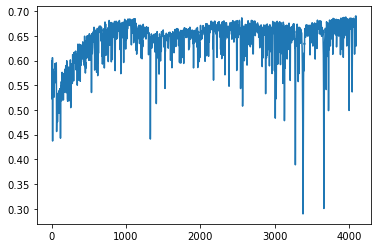

In [166]:
plt.plot(x_train[0])

In [11]:
x_train.shape

(100000, 4096)

In [211]:
with h5py.File(TEST_PATH, 'r') as f:
    v_flux = f['flux'][()]

In [212]:
assert not np.any(np.isnan(v_flux))
v_flux.shape

(10000, 4096)

In [162]:
def prepro(flux):
    log_flux= np.log(flux)    
#     vmin, vmax = np.min(log_flux), np.max(log_flux)    
    log_flux_norm = (log_flux - vmin) / (vmax- vmin)    
    return log_flux_norm

In [163]:
v_flux_norm = prepro(v_flux)

(array([6.7000000e+01, 9.7000000e+02, 4.0800000e+03, 8.2680000e+03,
        1.5641000e+04, 3.8686000e+04, 8.5181000e+04, 2.0536800e+05,
        9.3478200e+05, 3.9666957e+07]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

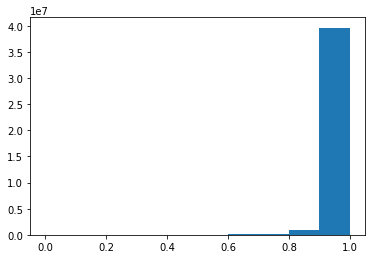

In [164]:
plt.hist(v_flux_norm.flatten())

In [182]:
x_train = 1- np.log(t_flux + 1) / np.log(2) 

In [184]:
x_train.min()

-0.008908964398967045

### AE

In [114]:
from viska.AE import Autoencoder

In [271]:
latent_dim = 2048

In [272]:
model = Autoencoder(latent_dim)

[4096, 2048]
Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spec (InputLayer)            [(None, 4096)]            0         
_________________________________________________________________
encoder (Functional)         (None, 2048)              8398848   
_________________________________________________________________
decoder (Functional)         (None, 4096)              8392704   
Total params: 16,791,552
Trainable params: 16,787,456
Non-trainable params: 4,096
_________________________________________________________________


In [273]:
# x_train = 1 - x_train
m = model
m.fit(x_train, ep=50)

Epoch 1/50
5625/5625 [==============================] - 13s 2ms/step - loss: 0.0285 - val_loss: 0.0079
Epoch 2/50
5625/5625 [==============================] - 12s 2ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 3/50
5625/5625 [==============================] - 12s 2ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 4/50
5625/5625 [==============================] - 11s 2ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 5/50
5625/5625 [==============================] - 12s 2ms/step - loss: 0.0080 - val_loss: 0.0053
Epoch 6/50
5625/5625 [==============================] - 12s 2ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 7/50
5625/5625 [==============================] - 12s 2ms/step - loss: 0.0079 - val_loss: 0.0041
Epoch 8/50
5625/5625 [==============================] - 12s 2ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 9/50
5625/5625 [==============================] - 12s 2ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 10/50
5625/5625 [==============================] - 11s 2ms/step - l

In [274]:
m = model
ae_val = m.ae.predict(x_train)

In [276]:
mse_err = np.sqrt(np.sum((x_train - ae_val)**2, axis = 1)).mean()
mae_err = np.sum(abs(x_train - ae_val), axis = 1).mean()

mse_err, mae_err

(0.4352687443627166, 21.792596133408647)

### Eval

In [42]:
from viska.eval_rec import *

In [217]:
np.max(np.log(v_flux + 1) / np.log(2))

1.0089044535484324

In [215]:
np.max(v_flux +1 )

1.0123823670188117

In [213]:
x_test = 1 - np.log(v_flux + 1) / np.log(2)
np.max(x_test), x_test.shape

(0.8888504495861103, (10000, 4096))

In [267]:
# x_test = 1 - v_flux
m = model
ae_pred = m.ae.predict(x_test)

In [268]:
err = np.sqrt(np.sum((x_test - ae_pred)**2, axis = 1)).mean()
err

0.5270771256629361

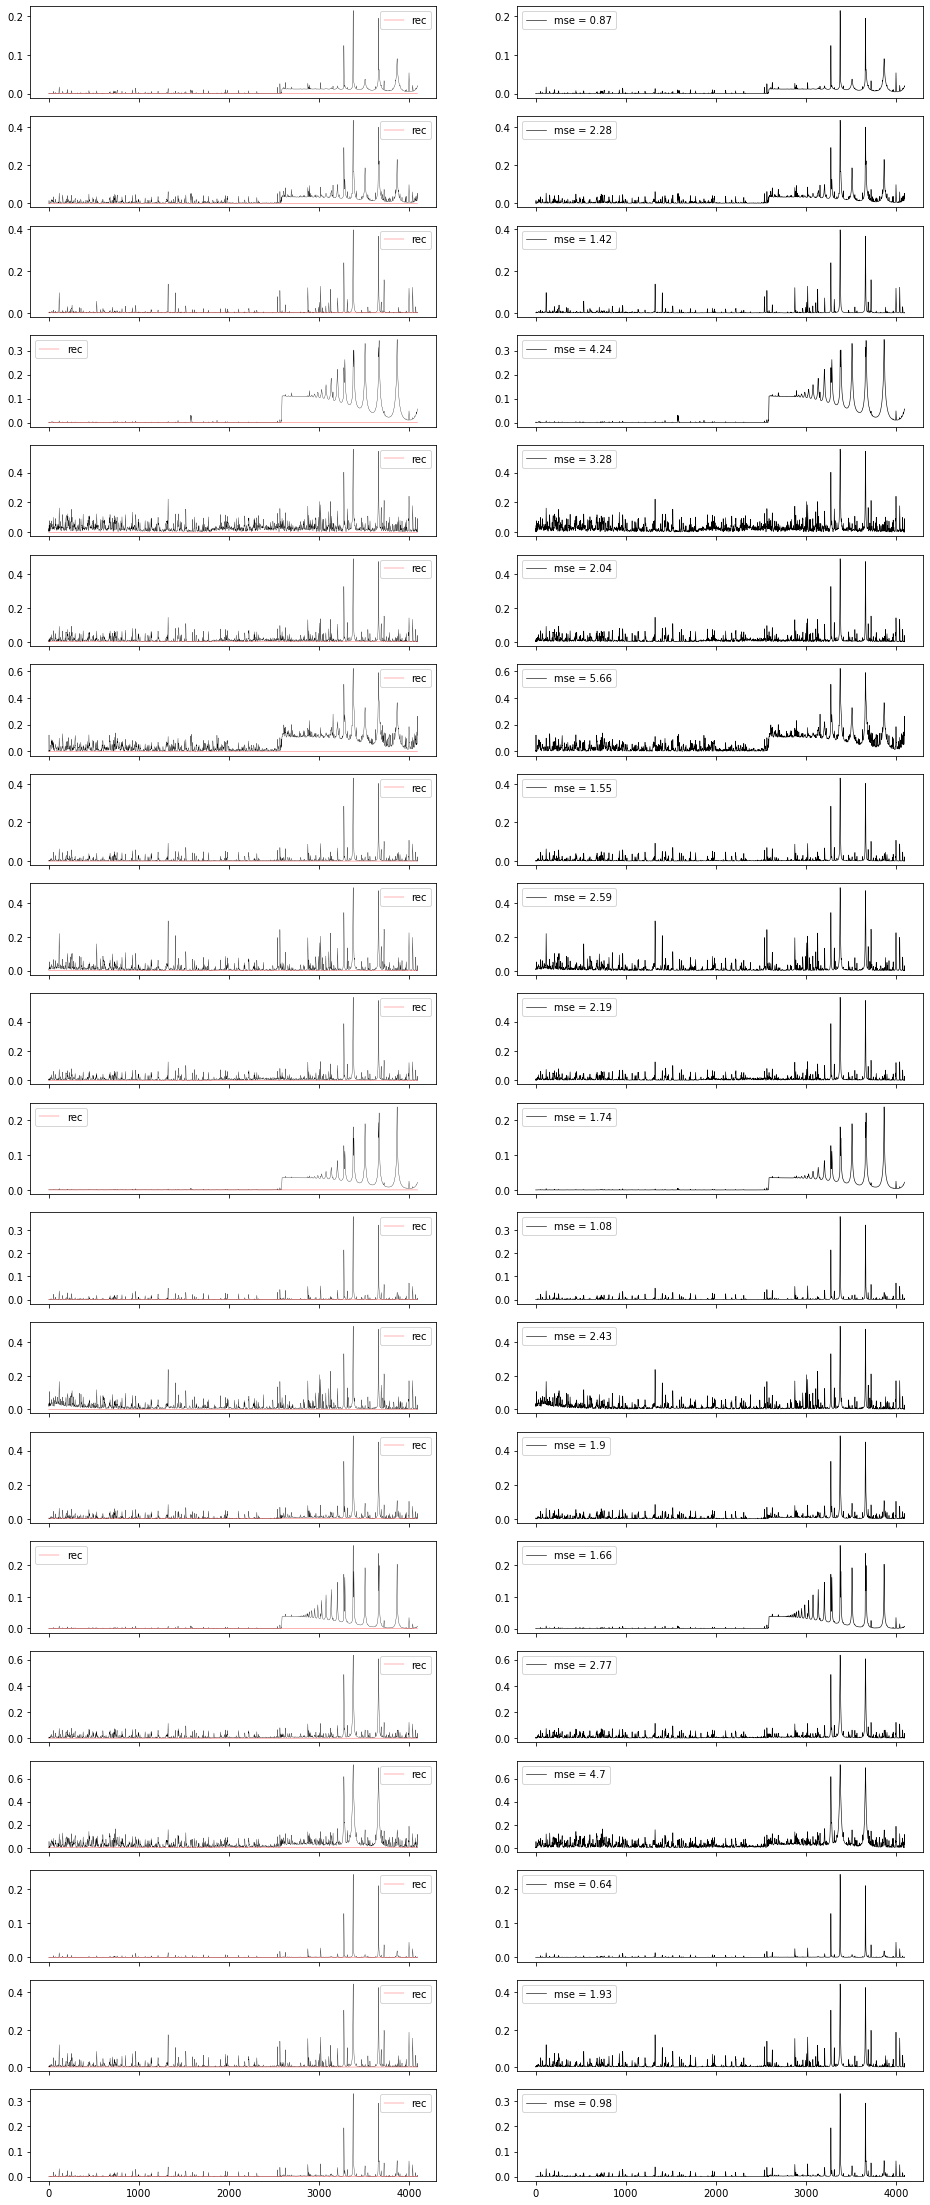

In [263]:
plot_rec(x_test, ae_pred, N=20, label='rec')

### PCA

In [97]:
with h5py.File(TRAIN_PATH, 'r') as f:
    u_train = f['U'][()]

In [100]:
with h5py.File(TEST_PATH, 'r') as f:
    pca_test = f['X'][()]

In [192]:
X, U_keep = pca_test, u_train[:, :latent_dim]
pca_pred = (X.dot(U_keep)).dot(U_keep.T)

In [193]:
err = np.sqrt(np.sum((pca_test - pca_pred)**2, axis = 1)).mean()
err

0.04892864180028026

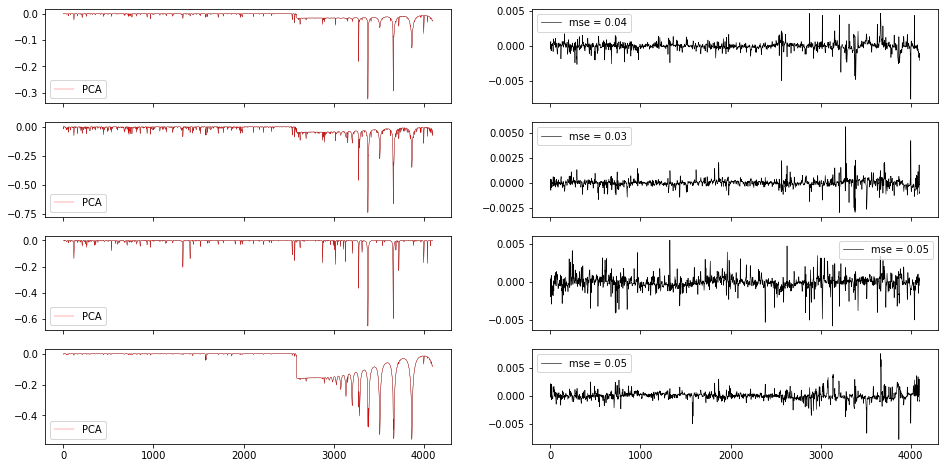

In [195]:
plot_pca_rec(pca_test, pca_pred, N=4)

### Latent Space

# Calculate principal components and expand on truncated basis

In [95]:
M = 50

PC = np.dot(X, U[:, 0:M])
PC.shape

(10000, 50)

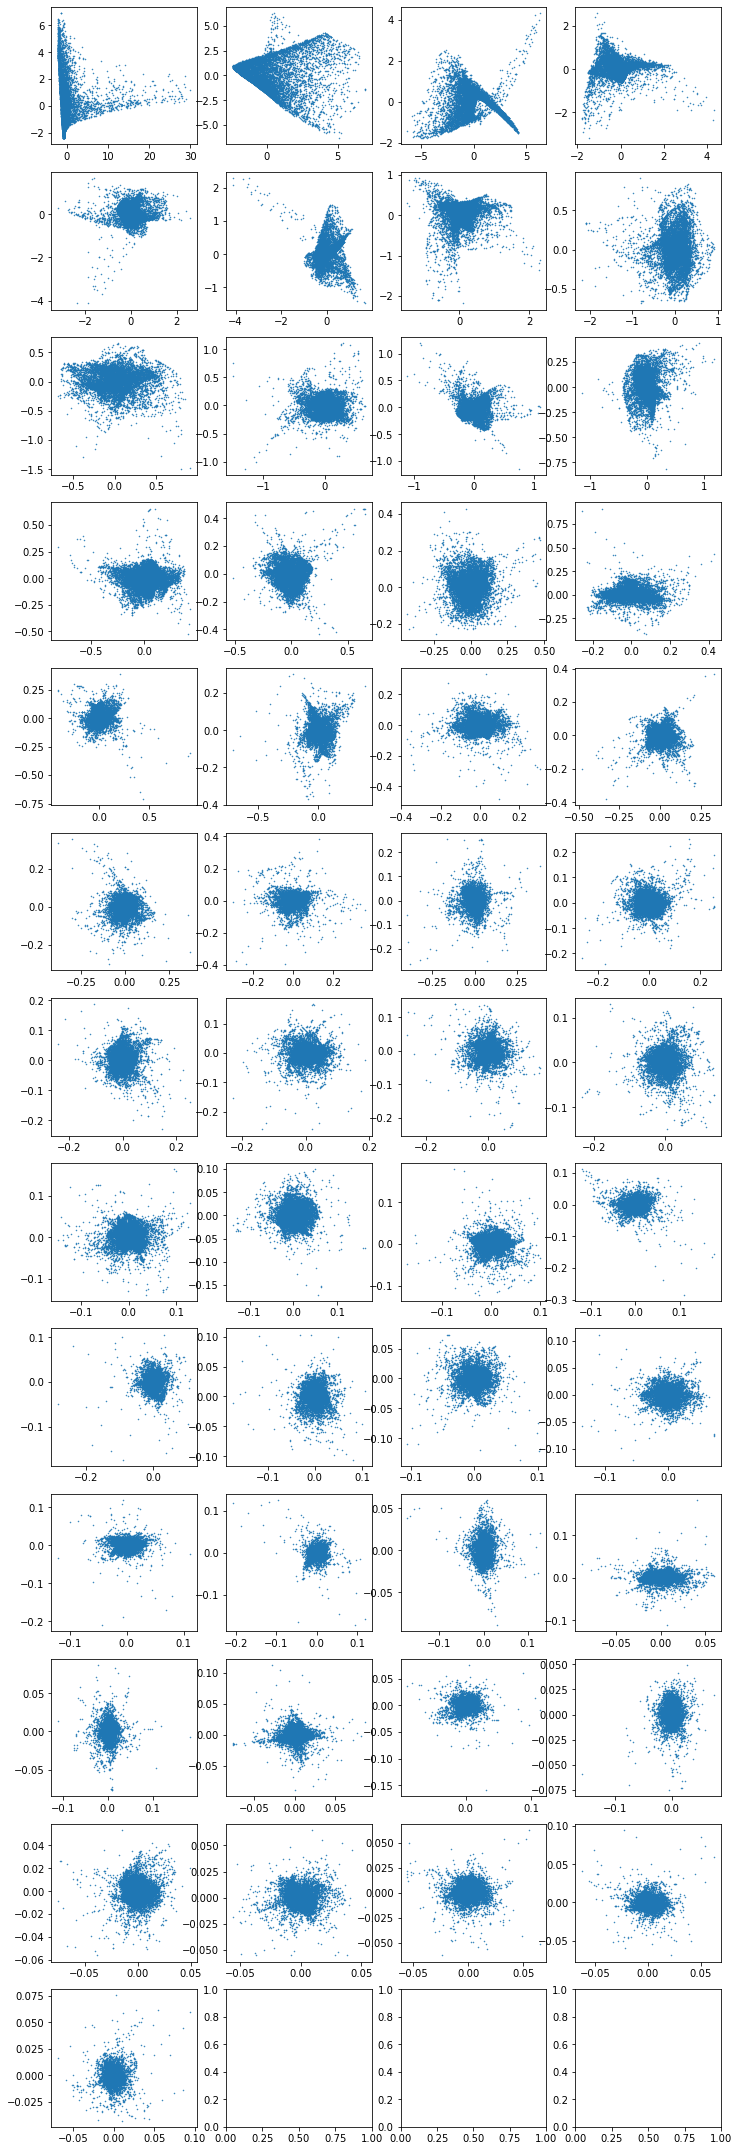

In [96]:
f, axs = plt.subplots(int(np.ceil(M / 4)), 4, figsize=(12, 3 * np.ceil(M / 4)))
axs = axs.flatten()

for i in range(M - 1):
    axs[i].plot(PC[:, i], PC[:, i + 1], '.', ms=1)

# Reconstruct from truncated basis

In [100]:
rflux = np.exp(avg + np.dot(PC, U[:, 0:M].transpose()))
rflux.shape

(10000, 4096)

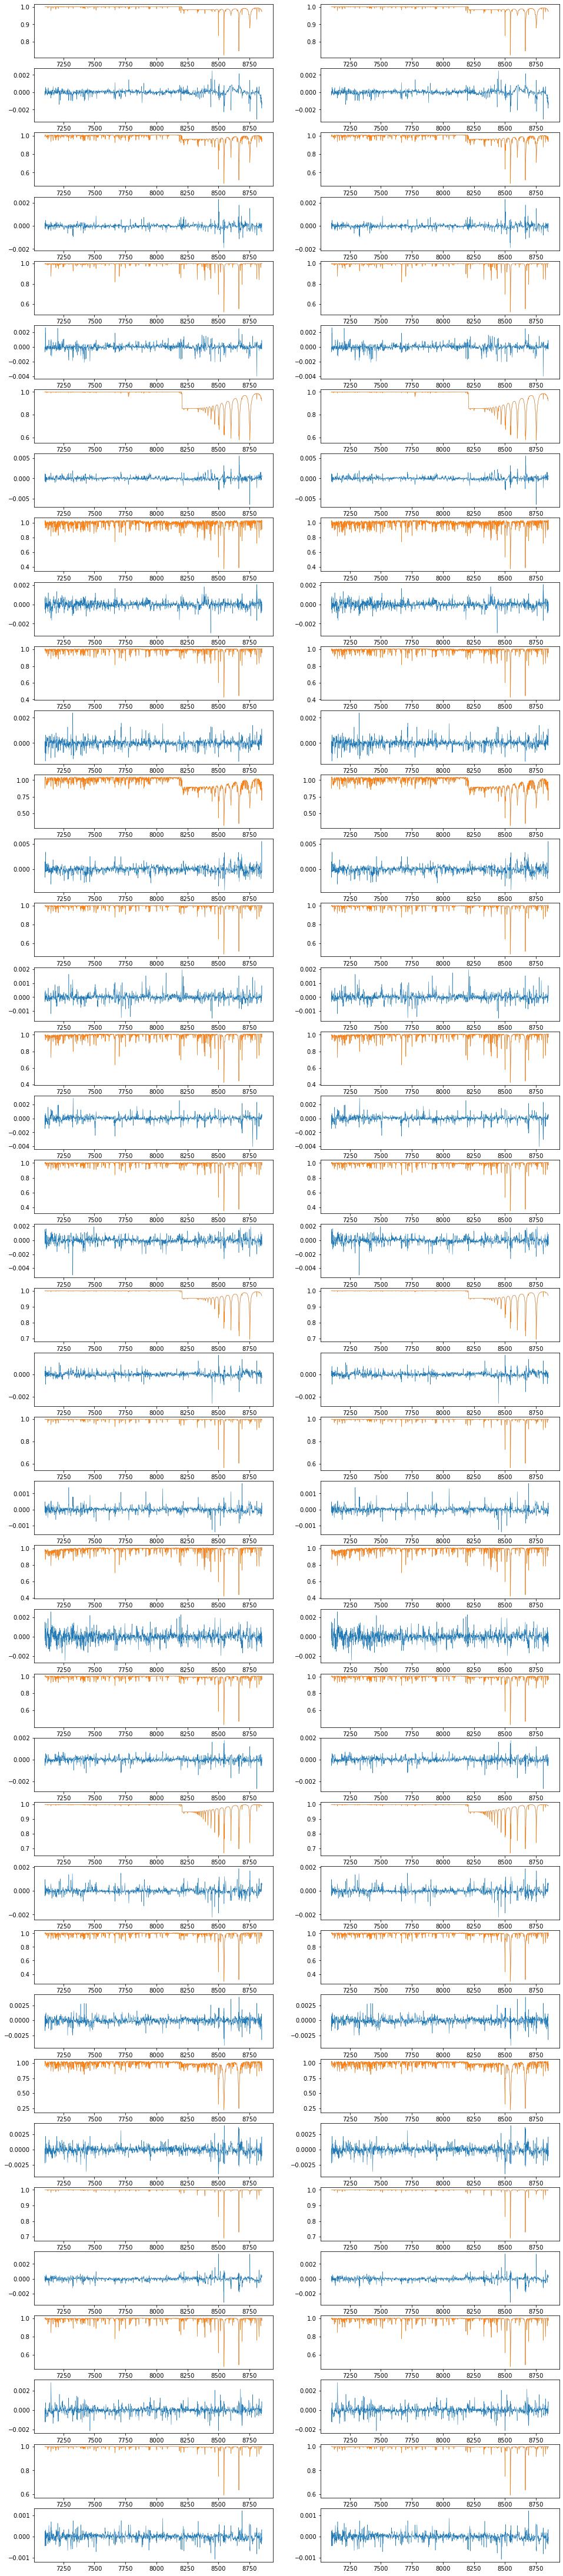

In [101]:
N = 20
f, axs = plt.subplots(2 * N, 2, figsize=(16, 4 * N), squeeze=False)

for i in range(N):
    axs[2 * i, 0].plot(wave, flux[i, :], lw=0.3)
    axs[2 * i, 0].plot(wave, rflux[i, :], lw=0.6)
    
    axs[2 * i, 1].plot(wave, flux[i, :], lw=0.3)
    axs[2 * i, 1].plot(wave, rflux[i, :], lw=0.6)
#     axs[2 * i, 1].set_xlim(8000, 9000)
    
    axs[2 * i + 1, 0].plot(wave, (flux[i, :] - rflux[i, :]) / flux[i, :], lw=0.5)
    
    axs[2 * i + 1, 1].plot(wave, (flux[i, :] - rflux[i, :]) / flux[i, :], lw=0.5)
#     axs[2 * i + 1, 1].set_xlim(8000, 9000)

In [ ]:
PC